# Sentiment Analysis by AraBERT

## Import libraries

In [1]:
!pip install emoji --upgrade
!pip install tashaphyne
!pip install transformers
!pip install torch
!pip install torchtext
!pip install datasets
!pip install pyarabic==0.6.14
!pip install demoji
!pip install contractions
!pip install langdetect
!pip install farasapy
!git clone https://github.com/aub-mind/arabert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.3/356.3 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.5.1-py2.py3-none-any.whl size=351210 sha256=81d765e3d6c02b47cb3f6c8c42032e456e4423154599e46800ab134c3e9098ed
  Stored in directory: /root/.cache/pip/wheels/51/92/44/e2ef13f803aa08711819357e6de0c5fe67b874671141413565
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.5/251.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 15.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8

In [2]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import os
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from textblob import TextBlob

from tashaphyne.stemming import ArabicLightStemmer
from nltk.stem.isri import ISRIStemmer

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

from farasa.segmenter import FarasaSegmenter
from arabert.preprocess import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# Transformers library for BERT
import transformers
from transformers import AutoTokenizer, AutoModel
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
stop_words = set(stopwords.words("arabic"))

# Initialize lemmatizer for text cleaning
ArListem = ArabicLightStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-2-4ed42e74d682>:58: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

## Data Import

Available: ['arabic', 'english', 'french', 'german', 'hindi', 'italian', 'portuguese', 'spanish', 'all']

In [3]:
from datasets import load_dataset
dataset_arb = load_dataset("cardiffnlp/tweet_sentiment_multilingual", 'arabic')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset tweet_sentiment_multilingual downloaded and prepared to /root/.cache/huggingface/datasets/cardiffnlp___tweet_sentiment_multilingual/arabic/0.1.0/936afd3cde120393429606f681b3b48d526873c45114068973f71e296ce80605. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
test_ar=pd.DataFrame(dataset_arb["test"])
validation_ar=pd.DataFrame(dataset_arb["validation"])
train_ar=pd.DataFrame(dataset_arb["train"])

In [5]:
train_ar.head()

,text,label
0,RT @user: @user @user وصلنا لاقتصاد اسوء من ...,0
1,كاني ويست، دريك، نيكي، بيونسيه، قاقا http,1
2,@user على فكره شركة محترمه حداعطوني كيبل كهديه...,2
3,RT @user: المتعه افضل من الزواج لهتك اعراض عام...,0
4,القوات البرية السعودية والقوات الفرنسية الخاصة...,1


In [6]:
train_ar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1839 non-null   object
 1   label   1839 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 28.9+ KB


First we rename the columns using shorter words for easier reference.

In [7]:
train_ar = train_ar.rename(columns={'label': 'sentiment'})
test_ar = test_ar.rename(columns={'label': 'sentiment'})
validation_ar = validation_ar.rename(columns={'label': 'sentiment'})

# Data Preparation: Preprocessing

Next, we will define custom functions to clean the texts of the tweets.

In [8]:
model="aubmindlab/bert-base-arabertv02"

In [9]:
arabic_prep = ArabertPreprocessor(model)

train_ar['text'] = train_ar['text'].apply(lambda x: arabic_prep.preprocess(x))
test_ar['text'] = test_ar['text'].apply(lambda x: arabic_prep.preprocess(x))
validation_ar['text'] = validation_ar['text'].apply(lambda x: arabic_prep.preprocess(x))

In [10]:
train_ar

,text,sentiment
0,RT [مستخدم] : [مستخدم] [مستخدم] وصلنا لاقتصاد ...,0
1,كاني ويست ، دريك ، نيكي ، بيونسيه ، قاقا [رابط],1
2,[مستخدم] على فكره شركة محترمه حداعطوني كيبل كه...,2
3,RT [مستخدم] : المتعه افضل من الزواج لهتك اعراض...,0
4,القوات البرية السعودية والقوات الفرنسية الخاصة...,1
...,...,...
1834,RT [مستخدم] : # أيفون _ البروفيسورمسابقة على أ...,1
1835,اللهم أنت السلام ومنك السلام تباركت يا ذا الجل...,2
1836,على وقع حمى الانتخابات الأميركية ويكليكس تكشف ...,0
1837,"[مستخدم] [مستخدم] على البي سي "" ويندوز 10 """,1


### Are there duplicate tweets after the cleaning?

In [11]:
train_ar.drop_duplicates("text", inplace=True)
test_ar.drop_duplicates("text", inplace=True)
validation_ar.drop_duplicates("text", inplace=True)

We removed the duplicated cleaned tweets. How is the class balance after the cleaning?

In [12]:
train_ar.sentiment.value_counts()
test_ar.sentiment.value_counts()
validation_ar.sentiment.value_counts()

0    108
1    108
2    108
Name: sentiment, dtype: int64

# Tweets length analysis

Now we will define a new dataframe column containing the length of the cleaned tweets in terms of number of words.

In [13]:
train_ar['text_len'] = [len(text.split()) for text in train_ar.text]
test_ar['text_len'] = [len(text.split()) for text in test_ar.text]
validation_ar['text_len'] = [len(text.split()) for text in validation_ar.text]

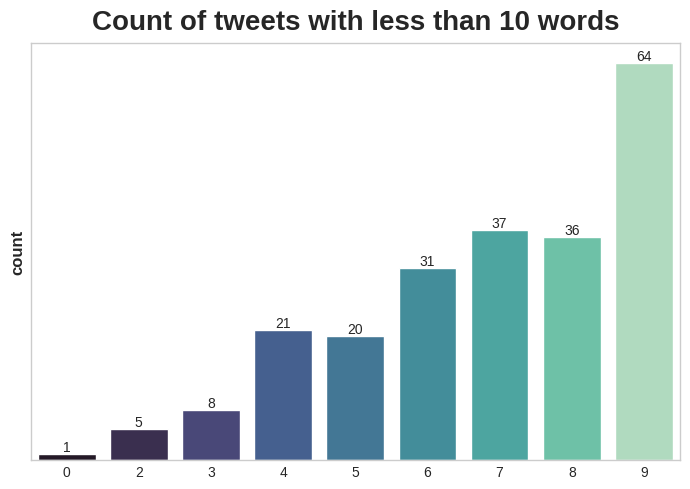

In [14]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=train_ar[train_ar['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

### What about long tweets?

In [15]:
train_ar.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_len
1405,RT [مستخدم] : علاقة مرسي ببشار ا سد وحلفاؤه . ...,1,41
818,RT [مستخدم] : # جمعتنا # POP _ ART - تدريس ألب...,2,38
1273,لأول مرة منذ 712 اسبوع بالتحديد في 17 - 2 - 20...,1,37
956,RT [مستخدم] : # قروب _ المحبه _ والموده # قروب...,2,37
796,والله حال العرب يرثى له ، ، المفروض كل العرب م...,1,36
...,...,...,...
1321,[مستخدم] بيونسيه,1,2
40,[مستخدم] بوكيمون,1,2
722,بمووت بيونسيه,2,2
829,[مستخدم] غوتشي,1,2


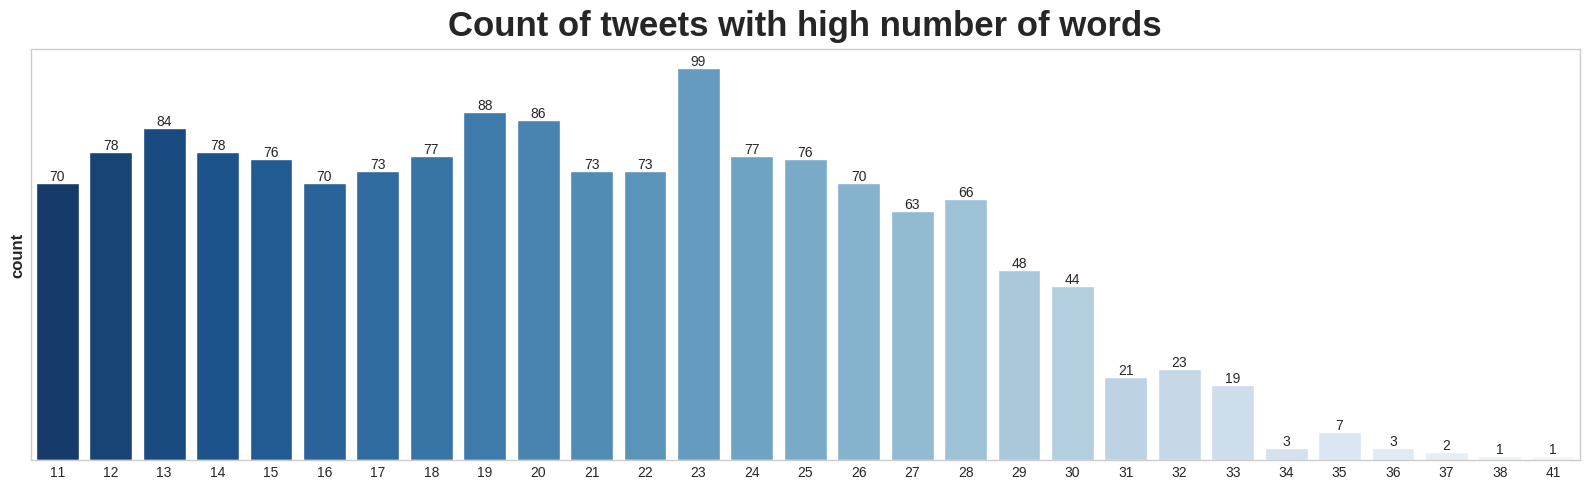

In [16]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=train_ar[(train_ar['text_len']<=1000) & (train_ar['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

We also will remove tweets that are too long (with more than 100 words).

In [17]:
train_ar = train_ar[train_ar['text_len'] < train_ar['text_len'].quantile(0.995)]

Then we also get the length of the longest tweet since it will be useful later.

In [18]:
max_len = np.max(train_ar['text_len'])
max_len

34

In [19]:
train_ar.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_len
1443,RT [مستخدم] : # الصرخي _ يردع _ داعش _ التكفير...,0,34
1108,RT [مستخدم] : عن شعوري و انت مش معايا يا كاريك...,1,34
1341,"RT [مستخدم] : هيلاري كلينتون : "" من الجيد أن ش...",0,34
824,RT [مستخدم] : كان طائفة من السلف يصومون عاشورا...,2,33
976,RT [مستخدم] : # اغبي _ سوال _ كتبته _ بقوقل # ...,1,33
...,...,...,...
40,[مستخدم] بوكيمون,1,2
722,بمووت بيونسيه,2,2
829,[مستخدم] غوتشي,1,2
1321,[مستخدم] بيونسيه,1,2


# BERT Classification

In this section, we will load a pre trained BERT model from the Hugging Face library and fine tune it for our classification task.

## Train - Validation - Test split

In [20]:
X_train = train_ar['text'].values
y_train = train_ar['sentiment'].values

In [21]:
X_test = test_ar['text'].values
y_test = test_ar['sentiment'].values

In [22]:
X_valid = validation_ar['text'].values
y_valid = validation_ar['sentiment'].values

# BERT Tokenization

Since we need to tokenize the tweets (get "input ids" and "attention masks") for BERT, we load the specific BERT tokenizer from the Hugging Face library.

In [23]:
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")

Then we define a custom tokenizer function using the loaded tokenizer.

In [24]:
def arabert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Since we need to specify the length of the longest tokenized sentence, we tokenize the train tweets using the "encode" method of the original BERT tokenizer and check the longest sentence.

In [25]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  58


We can choose the max length as 128.

In [26]:
MAX_LEN = 128

Then we can tokenize the train, validation and test tweets using the custom define tokenizer.

In [27]:
train_inputs, train_masks = arabert_tokenizer(X_train)
val_inputs, val_masks = arabert_tokenizer(X_valid)
test_inputs, test_masks = arabert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [28]:
train_masks.size()

torch.Size([1824, 128])

## Data preprocessing for PyTorch BERT model

Since we are using the BERT model built on PyTorch, we need to convert the arrays to pytorch tensors and create dataloaders for the data.

In [29]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

## Dataloaders

To fine-tune the BERT model, the original authors recommend a batch size of 16 or 32.

In [30]:
batch_size =16

In [31]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# BERT Modeling

Now we can create a custom BERT classifier class, including the original BERT model (made of transformer layers) and additional Dense layers to perform the desired classification task.

In [32]:
class araBert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(araBert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 3

        # Instantiate araBERT model
        self.bert = AutoModel.from_pretrained("aubmindlab/bert-base-arabertv02")

        # Instantiate the classifier (a fully connected layer followed by a ReLU activation and another fully connected layer)
        self.classifier = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, n_output)
        )

        # Freeze the BERT model weights if freeze_bert is True (useful for feature extraction without fine-tuning)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input data (input_ids and attention_mask) to araBERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the `[CLS]` token from the BERT output (useful for classification tasks)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed the extracted hidden state to the classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Moreover, since we want to define a learning rate scheduler, we define a custom "initalize_model" function as follows.

In [33]:
# Function for initializing the BERT Classifier model, optimizer, and learning rate scheduler
def initialize_model(epochs=4):
    # Instantiate araBert Classifier
    arabert_classifier = araBert_Classifier(freeze_bert=False)

    arabert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(arabert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Define the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return arabert_classifier, optimizer, scheduler

We also specify the use of GPU if present (highly recommended for the fine tuning)

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=10

And then we intialize the BERT model calling the "initialize_model" function we defined.

In [35]:
arabert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Us

# BERT Training

After defining the custom BERT classifier model, we are ready to start the training.

In [36]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def arabert_train(model, train_dataloader, val_dataloader=None, epochs=2, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1

            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###

        # Put the model into the evaluation mode
        model.eval()

        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)

            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)

        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")

    print("Training complete!")

In [37]:
arabert_train(arabert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.886476   |   36.33  
   113    |   0.688678   |   4.22   
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.863920    |  0.693957  |       67.86       |   42.77  
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.557343   |   33.49  
   113    |   0.438953   |   4.37   
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.543842    |  0.626453  |       75.30

# BERT Prediction

Now we define a function similar to the model "evaluation", where we feed to the model the test data instead of the validation data.

In [38]:
def arabert_predict(model, test_dataloader):

    # Define empty list to host the predictions
    preds_list = []

    # Put the model into evaluation mode
    model.eval()

    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]

        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)

        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

In [39]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16)
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [40]:
arabert_preds = arabert_predict(arabert_classifier, test_dataloader)

In [41]:
sentiments = ['Negative','Neutral','Positive']

In [42]:
print('Classification Report for araBERT :\n', classification_report(y_test, arabert_preds, target_names=sentiments))

Classification Report for araBERT :
               precision    recall  f1-score   support

    Negative       0.88      0.58      0.70       290
     Neutral       0.50      0.74      0.60       290
    Positive       0.74      0.64      0.69       290

    accuracy                           0.65       870
   macro avg       0.71      0.65      0.66       870
weighted avg       0.71      0.65      0.66       870



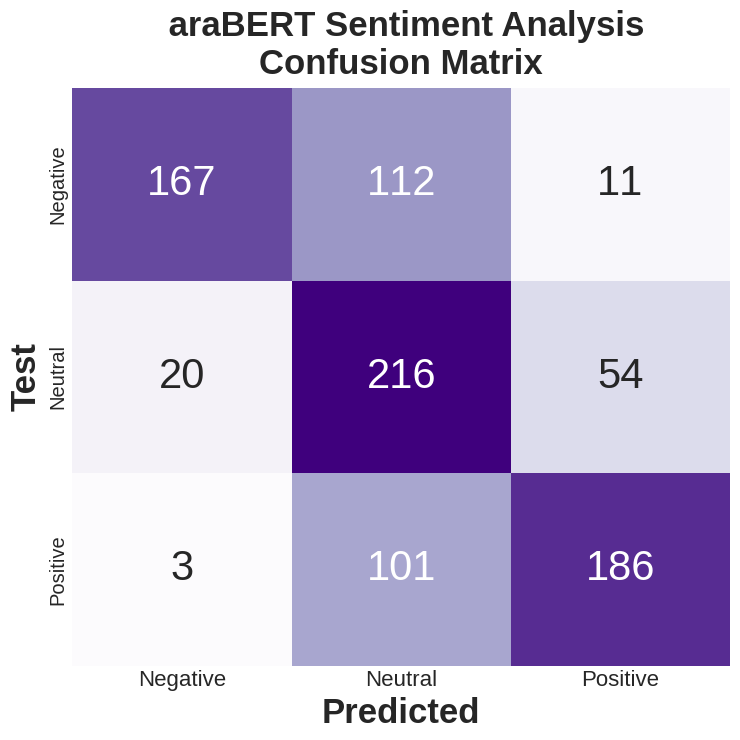

In [43]:
conf_matrix(y_test, arabert_preds,' araBERT Sentiment Analysis\nConfusion Matrix', sentiments)